In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rcParams
import time
from copy import copy

#from numba import int64

# #for 3d plots
# from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
# from mpl_toolkits.mplot3d import Axes3D
# #for 3d plots
# import matplotlib.animation as animation

#for saving simulations
# import pickle

from sim_handling import Simulation
from diffusionstuff7 import f2d

C:\Users\Max-PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\llvmlite\llvmpy\__init__.py:3: UserWarning: The module `llvmlite.llvmpy` is deprecated and will be removed in the future.
  warnings.warn(
C:\Users\Max-PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\llvmlite\llvmpy\core.py:8: UserWarning: The module `llvmlite.llvmpy.core` is deprecated and will be removed in the future. Equivalent functionality is provided by `llvmlite.ir`.
  warnings.warn(
C:\Users\Max-PC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\llvmlite\llvmpy\passes.py:17: UserWarning: The module `llvmlite.llvmpy.passes` is deprecated and will be removed in the future. If you are using this code, it should be inlined into your own project.
  warnings.warn(


In [2]:
# Graphics parameters
%matplotlib widget
ticklabelsize = 15
fontsize = 15
linewidth = 2
fignum = 0

In [3]:
test_f2d_sim = Simulation(f2d, (500,500), rtol=1e-12)
test_f2d_sim.layermax_2D = 5

0 0 0.06233027925721957 0.06233027925721957
6 1 2.021958237382603 1.9596279581253835
12 2 3.9046300766136595 1.8826718392310564
18 3 5.5917343737413825 1.687104297127723
24 4 7.238786587348126 1.6470522136067434
breaking because reached max number of layers grown


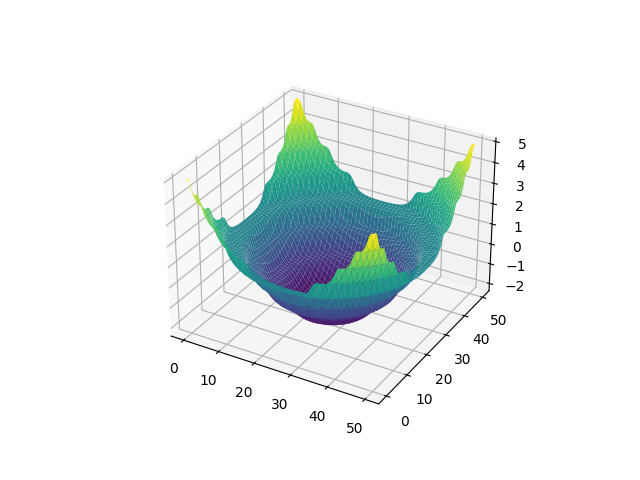

In [4]:
#test_f2d_sim.countermax_0D
#test_f2d_sim.countermax_1D
#test_f2d_sim.countermax_2D
#test_f2d_sim.atol
#test_f2d_sim.rtol
#test_f2d_sim.deltaT
#test_f2d_sim.float_params
#test_f2d_sim.animate()
#test_f2d_sim.run()
test_f2d_sim.plot()

In [5]:
num_steps = len(test_f2d_sim.results()['t'])
#shape of results is (num_steps, 2, nx, ny)
Fliq, Ntot = [],[]
for step in range(num_steps):
    next_Fliq, next_Ntot = test_f2d_sim._results['y'][step]
    Fliq.append(next_Fliq)
    Ntot.append(next_Ntot)    
Fliq,Ntot = np.array(Fliq), np.array(Ntot)
Nice = Ntot - Fliq
#shape of fliq, ntot and nice should be (num_steps, nx, ny)

#access coordinate arrays for plotting
xs, ys = np.meshgrid(test_f2d_sim.x, test_f2d_sim.y)

In [6]:
print(num_steps)
print(test_f2d_sim.steepness(0,slice(0,test_f2d_sim.shape[0]//2)))

26
[array([-0.05825406, -0.04225611, -0.03155454, -0.02805271, -0.0333793 ,
       -0.0491904 , -0.07686436, -0.11705891, -0.16919651, -0.23104738,
       -0.29864837, -0.36674138, -0.42969867, -0.48263112, -0.52225448,
       -0.54722628, -0.55794799, -0.55604364, -0.54376988, -0.52353078,
       -0.49756069, -0.46776318, -0.43566229, -0.40242054, -0.36888901,
       -0.33566735, -0.30316223, -0.27163923, -0.24126715, -0.21215522,
       -0.18438457, -0.15803571, -0.13321392, -0.11007439, -0.08884835,
       -0.06987065, -0.05360848, -0.04068911, -0.03192206, -0.0283071 ,
       -0.03101423, -0.04131658, -0.06045458, -0.08941571, -0.12863436,
       -0.17765743, -0.23487258, -0.29743074, -0.36147157, -0.42265967,
       -0.47689888, -0.52099676, -0.55307185, -0.5726191 , -0.5802895 ,
       -0.57751953, -0.56614579, -0.54809133, -0.52515489, -0.49889653,
       -0.47059546, -0.44125429, -0.41162805, -0.38226347, -0.35353954,
       -0.3257048 , -0.29890932, -0.27323117, -0.24869783, -

In [7]:
print(test_f2d_sim.get_step_density(0,slice(0,test_f2d_sim.shape[0]//2)))  

1.7332355848331815e-06
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
